Import packages

In [245]:
import pandas as pd
import numpy as np
import datetime
import re
import glob
import os
from tqdm import tqdm
from IPython import display

Scheme of ETL process

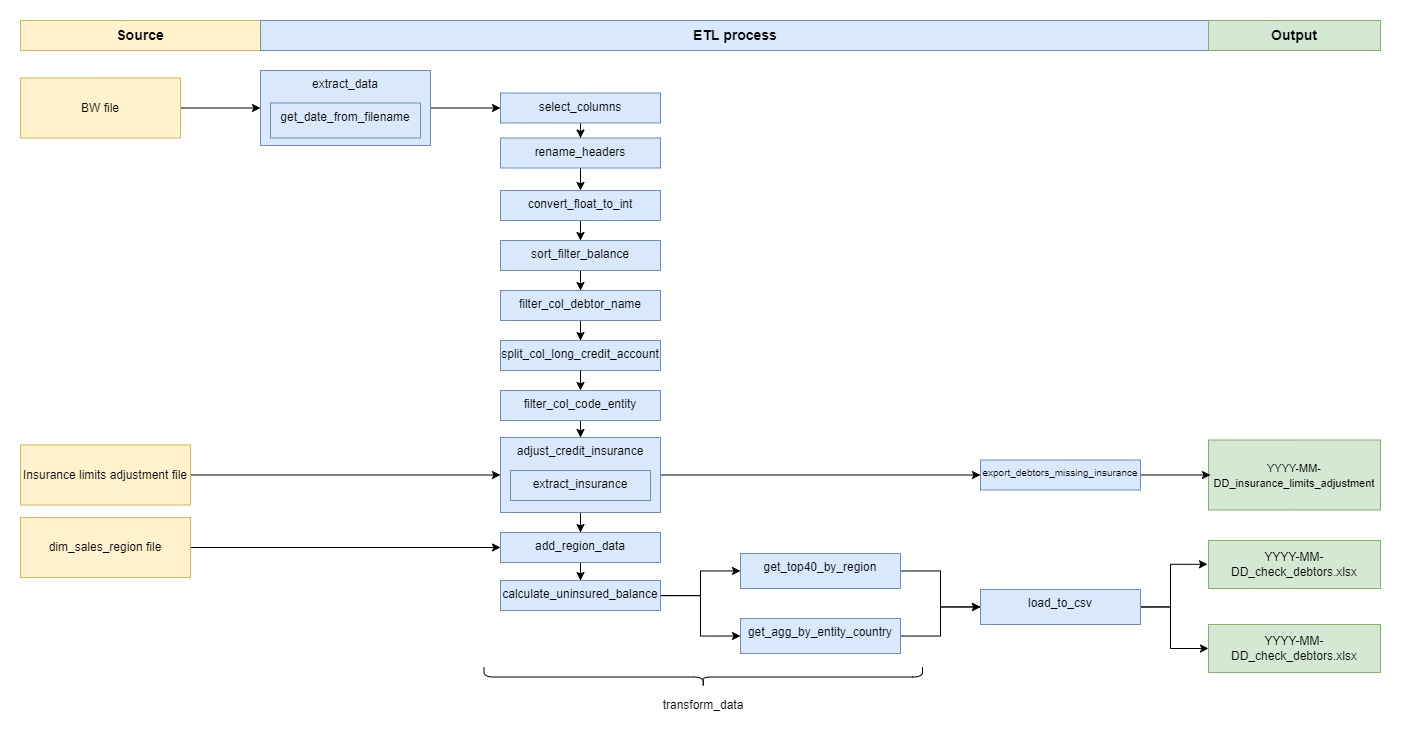

In [246]:
display.Image("etl_scheme_arm.jpg", height=800, width=1200)

1. Parameters

2. ETL process

2.1. Extract

In [248]:
def get_date_from_filename(file_name: str) -> str:
    """
    Extracts the date from a filename of the format 'ARM_YYYY-MM-DD.xlsx'.

    Parameters:
    - file_name (str): The name of the file to extract the date from.

    Returns:
    - str: The extracted date string in the format 'YYYY-MM-DD'.

    If the file name does not match the specified format, a message will be printed indicating the mismatch.
    If the extracted date is not a valid date, a message will be printed indicating the validation failure.

    Example:
    >>> get_date_from_filename('ARM_2024-04-09.xlsx')
    '2024-04-09'
    """
    pattern = r'^ARM_\d{4}-\d{2}-\d{2}\.xlsx$'
    if re.match(pattern, file_name):
        date_extracted = file_name.split('_')[1].split('.')[0]
    else:
        print(f"File name '{file_name}' does not match format ARM_YYYY-MM-DD.xlsx")
    
    try:
        datetime.date.fromisoformat(date_extracted)
        return date_extracted
    except ValueError as ve:
        print(f"Could not validate {date_extracted} as date. Error: {ve}")

In [250]:
def extract_data(file_name: str, folder_path: str) -> tuple[pd.DataFrame, str]:
    """
    Extracts data from an Excel file located in the specified folder.

    Parameters:
    - file_name (str): The name of the Excel file to extract data from.
    - folder_path (str): The path to the folder containing the Excel file.

    Returns:
    - tuple[pd.DataFrame, str]: A tuple containing the extracted DataFrame and the date string extracted from the filename.

    This function reads the Excel file located at 'folder_path/file_name' and skips the first 16 rows
    and the 17th row to extract relevant data. It also skips the last 15 rows. The date string extracted
    from the filename is returned along with the DataFrame containing the extracted data.

    If the specified file cannot be found in the given folder, an error message is printed.

    Example:
    >>> extract_data('ARM_2024-04-09.xlsx', '/path/to/folder')
    (DataFrame containing extracted data, '2024-04-09')
    """
    date_str = get_date_from_filename(file_name=file_name)

    file_path = folder_path + "/" + file_name
    rows_to_skip = [i for i in range(16)]
    rows_to_skip.append(17)
    
    try:
        df = pd.read_excel(file_path, skiprows=rows_to_skip, skipfooter=15)
        return df, date_str
    except Exception as error:
        print(f"Could not find {file_name} in {folder_path}.Error: {error}")

2.2. Transform

In [252]:
def select_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Selects specific columns from the DataFrame and standardizes column names.

    Parameters:
    - df (pd.DataFrame): The DataFrame from which columns are to be selected.

    Returns:
    - pd.DataFrame: A DataFrame containing only the selected columns.

    This function first standardizes column names by removing leading/trailing spaces, converting them to lowercase,
    and removing special characters such as ':', '.', and spaces. Then, it checks if all required columns are present
    in the DataFrame. If any column is missing, it prints a message indicating the missing columns.
    Finally, it selects and returns only the specified columns.

    Example:
    >>> select_columns(df)
    DataFrame with selected columns
    """
    df.columns = df.columns.str.strip().str.lower()
    df.columns = df.columns.str.replace(':', '').str.replace('.', '').str.replace(' ', '')

    # Checks if headers are available in the Dataframe
    select_cols = ['unnamed0', 'unnamed1', 'unnamed4', 'balance', 'due1-30d', 'due31-60d', 'due61-90d', 'due91-120d', 'due>120d', 'citotal', 'sall12m', 'secbank', 'secother']
    missing_cols = set(select_cols) - set(df.columns)
    if missing_cols:
        print(f"The following columns are missing in the DataFrame: {', '.join(missing_cols)}")
    df = df[select_cols]
    return df

In [254]:
def rename_headers(df: pd.DataFrame) -> pd.DataFrame:
   """
    Renames headers of the DataFrame to more descriptive names.

    Parameters:
    - df (pd.DataFrame): The DataFrame whose headers are to be renamed.

    Returns:
    - pd.DataFrame: A DataFrame with renamed headers.

    This function renames headers of the DataFrame according to the provided translation dictionary.
    Each header name is replaced with its corresponding value from the translation dictionary.
    If a header is not found in the translation dictionary, it remains unchanged.

    Example:
    >>> rename_headers(df)
    DataFrame with renamed headers
    """
   headers_translate = {'unnamed0': 'long_credit_account', 
                         'unnamed1': 'debtor_name', 
                         'unnamed4': 'code_country',
                         'due1-30d': 'due_1-30d', 
                         'due31-60d': 'due_31-60d',
                         'due61-90d': 'due_61-90d', 
                         'due91-120d': 'due_91-120d', 
                         'due>120d': 'due_over_120d', 
                         'citotal': 'credit_insurance', 
                         'sall12m': 'sales_last_12m', 
                         'secbank': 'security_bank', 
                         'secother': 'security_other'}
   df = df.rename(columns=headers_translate)
   return df

In [256]:
def convert_float_to_int(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts float columns in the DataFrame to integer type.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing columns to be converted.

    Returns:
    - pd.DataFrame: A DataFrame with float columns converted to integer type.

    This function iterates through columns of float type in the DataFrame and attempts to convert them to integer type.
    If conversion is successful, the column is converted; otherwise, an error message is printed.
    Any non-convertible columns are left unchanged.

    Example:
    >>> convert_float_to_int(df)
    DataFrame with float columns converted to integer type
    """
    # Temporarily disable the warning for chained assignment
    with pd.option_context('mode.chained_assignment', None):
        for col in df.select_dtypes(include='float').columns:
            try:
                df[col] = df[col].astype(np.int64)
            except ValueError as ve:
                print(f"Error while converting column '{col}' to integer: {ve}")
        return df

In [258]:
def sort_filter_balance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters and sorts the DataFrame based on positive balance values.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be filtered and sorted.

    Returns:
    - pd.DataFrame: A DataFrame filtered for positive balance values and sorted in descending order by balance.

    This function filters the DataFrame to include only rows where the balance is greater than 0.
    It then sorts the filtered DataFrame based on the 'balance' column in descending order.

    Example:
    >>> sort_filter_balance(df)
    DataFrame filtered and sorted by positive balance values
    """
    df = df.loc[df['balance'] > 0]
    df = df.sort_values(by=['balance'], ascending=False)
    return df

In [260]:
def filter_col_debtor_name(df: str, debtors_to_drop: list) -> pd.DataFrame:
    """
    Filters the DataFrame to exclude rows with specified debtor names.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be filtered.
    - debtors_to_drop (list): A list of debtor names to be excluded.

    Returns:
    - pd.DataFrame: A DataFrame with rows containing specified debtor names excluded.

    This function converts the 'debtor_name' column to lowercase, then filters out rows
    where the 'debtor_name' contains any of the specified names in the 'debtors_to_drop' list.
    Finally, it converts the 'debtor_name' column back to title case.

    Example:
    >>> filter_col_debtor_name(df, ['debtor1', 'debtor2'])
    DataFrame with specified debtor names filtered out
    """
    try:
        df.loc[:,'debtor_name'] = df.loc[:,'debtor_name'].str.lower()
        # Create a '|'-separated string from debtors_to_drop
        debtors_to_drop = '|'.join(debtors_to_drop)
        # Filter rows where debtor_name contains any of the specified names
        df = df.loc[~df['debtor_name'].str.contains(debtors_to_drop, na=False),:]
        df.loc[:,'debtor_name'] = df.loc[:,'debtor_name'].str.title()
        return df
    except Exception as error:
        print(f"Error while filtering debtor names: {error}")

In [262]:
def split_col_long_credit_account(df: pd.DataFrame) -> pd.DataFrame:
    """
    Splits the 'long_credit_account' column into separate columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the 'long_credit_account' column to be split.

    Returns:
    - pd.DataFrame: A DataFrame with the 'long_credit_account' column split into separate columns.

    This function splits the 'long_credit_account' column into three separate columns:
    'code_company', 'credit_account', and a temporary column (to be deleted).
    The temporary column ('col_to_del') is then dropped from the DataFrame.

    Example:
    >>> split_col_long_credit_account(df)
    DataFrame with 'long_credit_account' column split into separate columns
    """
    df[['col_to_del', 'code_company', 'credit_account']] = df['long_credit_account'].str.split('/', expand=True)
    df = df.drop(columns='col_to_del')
    return df

In [264]:
def filter_col_code_entity(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the DataFrame to exclude rows with specified company codes.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be filtered.

    Returns:
    - pd.DataFrame: A DataFrame with rows containing specified company codes excluded.

    This function filters out rows from the DataFrame where the 'code_company' column contains
    any of the specified company codes to drop. It then resets the index of the DataFrame.

    Example:
    >>> filter_col_code_entity(df)
    DataFrame with specified company codes filtered out
    """
    try:
        company_code_to_drop = ['0000', '0001', '0002', '0003']
        company_code_to_drop = '|'.join(company_code_to_drop)
        df = df[~df['code_company'].str.contains(company_code_to_drop)]
        df = df.reset_index(drop=True)
        return df
    except Exception as error:
        print(f"Error while dropping entities: {error}")

Correct credit insurance

In [266]:
def extract_insurance(date_str: str, path: str) -> pd.DataFrame:
    """
    Extracts insurance data for a specific date from a CSV file.

    Parameters:
    - date_str (str): The date string in the format 'YYYY-MM-DD'.
    - path (str): The path to the folder containing the CSV files.

    Returns:
    - pd.DataFrame: A DataFrame containing insurance data extracted for the specified date.

    This function extracts insurance data for a specific date from a CSV file located in the specified folder.
    It first converts the input date string to 'YYYY-MM' format to match the CSV file naming convention.
    Then, it searches for a CSV file with a filename containing the formatted date string.
    The insurance data is read from the CSV file into a DataFrame, and only the 'long_credit_account' and
    'credit_limit' columns are selected.

    Example:
    >>> extract_insurance('2024-04-09', '/path/to/folder')
    DataFrame with insurance data for the specified date
    """
    date_yyyy_mm = datetime.datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y-%m')
    file_path_insurance = glob.glob(path + "/*" + date_yyyy_mm + "*")[0]
    df_insurance = pd.read_csv(file_path_insurance, dtype={'credit_limit': np.int64})
    df_insurance = df_insurance[['long_credit_account', 'credit_limit']]
    return df_insurance

In [267]:
def adjust_credit_insurance(df: pd.DataFrame, date_str: str, path_insurace_adjustment: str) -> pd.DataFrame:
    """
    Adjusts credit insurance values in the DataFrame based on insurance data for a specific date.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing credit insurance values to be adjusted.
    - date_str (str): The date string in the format 'YYYY-MM-DD'.
    - path_insurace_adjustment (str): The path to the folder containing insurance adjustment data.

    Returns:
    - pd.DataFrame: A DataFrame with adjusted credit insurance values.

    This function adjusts credit insurance values in the DataFrame based on insurance data for a specific date.
    It extracts insurance data for the specified date using the 'extract_insurance' function.
    Then, it merges the insurance data with the original DataFrame based on the 'long_credit_account' column.
    Next, it replaces credit insurance values with credit limits where credit insurance is 0 and credit limits are available.
    Finally, it converts the adjusted credit insurance values to integer type and drops the 'credit_limit' column.

    Example:
    >>> adjust_credit_insurance(df, '2024-04-09', '/path/to/insurance_adjustment_folder')
    DataFrame with adjusted credit insurance values
    """
    try: 
        df_insurance = extract_insurance(date_str=date_str, path=path_insurace_adjustment)
        df = df.merge(df_insurance, how='left', on='long_credit_account')
        
        condition_limit_replacement = np.logical_and(df['credit_insurance'] == 0, df['credit_limit'].notna())
        df['credit_insurance'] = np.where(condition_limit_replacement, df['credit_limit'], df['credit_insurance'])
        df['credit_insurance'] = df['credit_insurance'].astype('int64')
        df_adjusted = df.drop(columns=['credit_limit'])
        return df_adjusted
    except Exception as error:
        print(f"Could adjust credit limits.Error message: {error}")
        return df

Export customers with no credit insurance

In [269]:
def export_debtors_missing_insurance(df: pd.DataFrame, date_str: str, path: str) -> pd.DataFrame:
    """
    Exports debtors with missing insurance to an Excel file.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing debtor data.
    - date_str (str): The date string in the format 'YYYY-MM-DD'.
    - path (str): The path to the folder where the Excel file will be saved.

    Returns:
    - None

    This function filters the DataFrame to select debtors with certain company codes ('1000', '2000', etc.)
    and balances greater than or equal to 15000, but with credit insurance values of 0.
    It then sorts the selected debtors by company code and balance.
    The filtered DataFrame is exported to an Excel file with a filename based on the specified date.

    Example:
    >>> export_debtors_missing_insurance(df, '2024-04-09', '/path/to/folder')
    Excel file exported containing debtors with missing insurance
    """
    try:
        condition_get_debtors = np.logical_and(df['code_company'].isin(['1000', "2000", "3000", "4000", "5000", "6000"]),
                                np.logical_and(df['balance'] >= 15000, df['credit_insurance'] == 0))
        df_missing_insurance = df.loc[condition_get_debtors, ].sort_values(by=['code_company', 'balance'])
        
        output_file_name = f'{date_str}_check_debtors.xlsx'
        destination_output_file = f'{path}/{output_file_name}'
        return df_missing_insurance.to_excel(destination_output_file, index=False)
    except Exception as error:
        print(f"Could not export missing insurance. Error message: {error}")

Continue transform

In [271]:
def add_region_data(df: pd.DataFrame, file_path_region: str) -> pd.DataFrame:
    """
    Adds region data to the DataFrame based on company codes.

    Parameters:
    - df (pd.DataFrame): The DataFrame to which region data will be added.
    - file_path_region (str): The file path to the CSV file containing region data.

    Returns:
    - pd.DataFrame: A DataFrame with region data added.

    This function reads region data from a CSV file and merges it with the input DataFrame based on the 'code_company' column.
    Only columns 'code_company', 'tax_rate', and 'sales_region' are selected from the region DataFrame for the merge.

    Example:
    >>> add_region_data(df, '/path/to/region_data.csv')
    DataFrame with region data added
    """
    try:
        col_type_region = {'code_company': str, 'company_name_short': str, 'tax_rate': float}
        df_region = pd.read_csv(file_path_region, sep=';', decimal=',', dtype=col_type_region, encoding='cp1252')
        df_region = df_region[['code_company', 'tax_rate', 'sales_region']]
        df = df.merge(df_region, how='left', on='code_company')
        return df
    except Exception as error:
        print(f"Could not load data from {file_path_region}.\n{error}")   

In [273]:
def calculate_uninsured_balance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the uninsured balance for each debtor in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing debtor data.

    Returns:
    - pd.DataFrame: A DataFrame with the uninsured balance calculated and added as a new column.

    This function calculates the uninsured balance for each debtor by subtracting collateral values
    (bank security and other security) from the balance, dividing the result by (1 + tax_rate), and then
    subtracting the credit insurance value. If the calculated uninsured balance is negative, it is adjusted to 0.
    The 'balance_unsecured' column is added to the DataFrame to store the uninsured balance, and the 'tax_rate'
    column is dropped from the DataFrame.

    Example:
    >>> calculate_uninsured_balance(df)
    DataFrame with uninsured balance calculated and added as a new column
    """
    try:
        balance_minus_colateral_gross = df['balance'] - (df['security_bank'] + df['security_other'])
        tax_rate_plus1 = 1 + df['tax_rate']
        uninsured_balance = (balance_minus_colateral_gross / tax_rate_plus1) - df['credit_insurance']
        uninsured_balance_adj = np.maximum(uninsured_balance, 0)
        df['balance_unsecured'] = uninsured_balance_adj.astype('int32')
        df = df.drop(columns="tax_rate")
        return df
    except Exception as error:
        print(f"Error while calculating uninsured balance: {error}")

In [275]:
def calculate_due_adjusted(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the adjusted due amount for each row in the DataFrame.

    This function sums the values in the columns 'due_1-30d', 'due_31-60d', 'due_61-90d',
    'due_91-120d', and 'due_over_120d' for each row. It then creates a new column
    'due_adjusted' where negative sums are replaced with 0.

    Args:
        df (pd.DataFrame): Input DataFrame containing columns 'due_1-30d', 'due_31-60d',
                           'due_61-90d', 'due_91-120d', and 'due_over_120d'.

    Returns:
        pd.DataFrame: DataFrame with an additional column 'due_adjusted'.

    Raises:
        Exception: If there is an error during the calculation, an exception is caught
                   and an error message is printed.
    """
    try:
        due = df.loc[:, ['due_1-30d', 'due_31-60d', 'due_61-90d', 'due_91-120d', 'due_over_120d']].sum(axis = 1)
        df['due_adjusted'] = np.where(due < 0, 0, due)
        return df
    except Exception as error:
        print(f"Error while calculating uninsured balance: {error}")

In [276]:
def calculate_due_over_90d_adjusted(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the adjusted due amount for the overdue balances over 90 days.

    This function sums the values in the columns 'due_91-120d' and 'due_over_120d' for
    each row to create a new column 'due_over_90d'. It then creates another column 
    'due_over_90d_adjusted' where values greater than 'due_adjusted' are replaced by 
    'due_adjusted', and negative values are replaced with 0. Finally, it drops the 
    intermediate column 'due_over_90d'.

    Args:
        df (pd.DataFrame): Input DataFrame containing columns 'due_91-120d', 
                           'due_over_120d', and 'due_adjusted'.

    Returns:
        pd.DataFrame: DataFrame with an additional column 'due_over_90d_adjusted' and
                      the intermediate column 'due_over_90d' removed.

    Raises:
        Exception: If there is an error during the calculation, an exception is caught
                   and an error message is printed.
    """
    try:
        df['due_over_90d'] = df.loc[:, ['due_91-120d', 'due_over_120d']].sum(axis = 1)
        
        df['due_over_90d_adjusted'] = df['due_over_90d']
        df.loc[df['due_over_90d'] > df['due_adjusted'], 'due_over_90d_adjusted'] = df['due_adjusted']
        df.loc[0 > df['due_over_90d'], 'due_over_90d_adjusted'] = 0

        df = df.drop(columns='due_over_90d')
        return df
    except Exception as error:
        print(f"Error while calculating uninsured balance: {error}")

In [279]:
def get_top40_by_region(df: pd.DataFrame, date_str: str) -> pd.DataFrame:
    """
    Retrieves the top 40 debtors by region for the specified date.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing debtor data.
    - date_str (str): The date string in the format 'YYYY-MM-DD'.

    Returns:
    - pd.DataFrame: A DataFrame containing the top 40 debtors by region for the specified date.

    This function filters out specific debtors from the DataFrame, groups the remaining debtors by sales region,
    and selects the top 40 debtors in each region based on their balance. It then formats the resulting DataFrame
    to include only relevant columns and inserts the specified date as a new column.

    Example:
    >>> get_top40_by_region(df, '2024-04-09')
    DataFrame containing the top 40 debtors by region for the specified date
    """
    try:
        df = filter_col_debtor_name(df=df, debtors_to_drop = ['aaa', 'bbb', 'ccc'])
        df_top40_by_region = df.groupby('sales_region').apply(lambda x: x.nlargest(40, 'balance')).reset_index(drop=True)
        df_top40_by_region = df_top40_by_region[['long_credit_account', 'code_company', 'code_country', 'credit_account', 'debtor_name', 'balance', 'balance_unsecured', 'credit_insurance', 'security_bank', 'security_other', 'due_1-30d', 'due_31-60d', 'due_61-90d', 'due_91-120d', 'due_over_120d', 'due_adjusted', 'due_over_90d_adjusted', 'sales_last_12m']]
        df_top40_by_region.insert(0, 'date', date_str)
        return df_top40_by_region
    except Exception as error:
        print(f"Error occurred while getting top40 debtors by region: {error}")

In [281]:
def get_agg_by_entity_country(df: pd.DataFrame, date_str: str) -> pd.DataFrame:
    """
    Aggregates debtor data by entity code and country for the specified date.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing debtor data.
    - date_str (str): The date string in the format 'YYYY-MM-DD'.

    Returns:
    - pd.DataFrame: A DataFrame containing aggregated debtor data by entity code and country for the specified date.

    This function aggregates debtor data by entity code and country, summing up the values of various columns such as
    'balance', 'balance_unsecured', 'due_1-30d', etc. The resulting DataFrame includes the aggregated values along with
    the specified date as a new column.

    Example:
    >>> get_agg_by_entity_country(df, '2024-04-09')
    DataFrame containing aggregated debtor data by entity code and country for the specified date
    """
    agg_entity_country = {
            'balance': 'sum',
            'balance_unsecured': 'sum',
            'due_1-30d': 'sum',
            'due_31-60d': 'sum',
            'due_61-90d': 'sum',
            'due_91-120d': 'sum',
            'due_over_120d': 'sum',
            'due_adjusted': 'sum',
            'due_over_90d_adjusted': 'sum',
            'sales_last_12m': 'sum'
        }
    try:
        df_entity_country = df.groupby(['code_company', 'code_country'], as_index=False).agg(agg_entity_country)
        df_entity_country.insert(0, 'date', date_str)
        return df_entity_country
    except Exception as error:
        print(f"Error occurred while aggregating by entity code and country: {error}")

In [283]:
def get_full_df(df: pd.DataFrame, date_str: str) -> pd.DataFrame:
    """
    Create a DataFrame with a specified set of columns and add a date column.

    This function selects specific columns from the input DataFrame and inserts a new 
    column 'date' at the beginning, with the value provided by `date_str`.

    Args:
        df (pd.DataFrame): Input DataFrame containing columns 'long_credit_account', 
                           'code_company', 'credit_account', 'debtor_name', 'code_country', 
                           'sales_region', 'balance', 'due_1-30d', 'due_31-60d', 'due_61-90d', 
                           'due_91-120d', 'due_over_120d', 'due_adjusted', 'due_over_90d_adjusted', 
                           'credit_insurance', 'sales_last_12m', 'security_bank', 'security_other', 
                           'balance_unsecured'.
        date_str (str): Date string to be added as a new column.

    Returns:
        pd.DataFrame: A DataFrame with the specified columns from the input DataFrame 
                      and an additional 'date' column at the beginning.

    Raises:
        Exception: If there is an error during the processing, an exception is caught 
                   and an error message is printed.
    """
    try:
        df_full = df[['long_credit_account', 'code_company', 'credit_account', 'debtor_name', 'code_country', 'sales_region','balance','due_1-30d', 'due_31-60d', 'due_61-90d', 'due_91-120d', 'due_over_120d','due_adjusted', 'due_over_90d_adjusted', 'credit_insurance', 'sales_last_12m', 'security_bank', 'security_other', 'balance_unsecured']]
        df_full.insert(0, 'date', date_str)
        return df_full
    except Exception as error:
        print(f"Error occurred while getting top40 debtors by region: {error}")

In [295]:
def transform_data(df: pd.DataFrame, date_str: str, folder_path_insurance: str, folder_path_missing_insurance: str, file_path_region: str) -> tuple[pd.DataFrame, pd.DataFrame]: 
    """
    Transforms debtor data for analysis and reporting.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing debtor data.
    - date_str (str): The date string in the format 'YYYY-MM-DD'.
    - folder_path_insurance (str): The folder path containing insurance adjustment data.
    - folder_path_missing_insurance (str): The folder path where the Excel file of debtors with missing insurance will be saved.
    - file_path_region (str): The file path to the CSV file containing region data.

    Returns:
    - tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two DataFrames: one with top 40 debtors by region and another with aggregated debtor data by entity code and country.

    This function applies a series of transformations to the input DataFrame to prepare debtor data for analysis and reporting.
    It performs column selection, renaming, data type conversion, sorting, filtering, splitting, merging, calculation, and aggregation.
    Finally, it exports debtors with missing insurance to an Excel file and returns DataFrames containing top 40 debtors by region
    and aggregated debtor data by entity code and country.

    Example:
    >>> transform_data(df, '2024-04-09', '/path/to/insurance_adjustment_folder', '/path/to/missing_insurance_folder', '/path/to/region_data.csv')
    (DataFrame with top 40 debtors by region, DataFrame with aggregated debtor data by entity code and country)
    """
    df = select_columns(df=df)
    df = rename_headers(df=df)
    df = convert_float_to_int(df=df)
    df = sort_filter_balance(df=df)
    df = filter_col_debtor_name(df=df, debtors_to_drop = ['aaa', 'bbb', 'ccc', 'ddd'])
    df = split_col_long_credit_account(df=df)
    df = filter_col_code_entity(df)

    df = adjust_credit_insurance(df=df, date_str=date_str, path_insurace_adjustment=folder_path_insurance)
    export_debtors_missing_insurance(df=df, date_str=date_str, path=folder_path_missing_insurance)

    df = add_region_data(df=df, file_path_region=file_path_region)
    df = calculate_uninsured_balance(df=df)
    df = calculate_due_adjusted(df=df)
    df = calculate_due_over_90d_adjusted(df=df)
    
    df_top40 = get_top40_by_region(df=df, date_str=date_str)
    df_agg = get_agg_by_entity_country(df=df, date_str=date_str)
    df_full = get_full_df(df=df, date_str=date_str)

    return df_top40, df_agg, df_full

2.3. Load

In [287]:
def load_to_csv(df: pd.DataFrame, destination_path: str, reporting_date: str, df_export_name: str):
    """
    Exports a DataFrame to a CSV file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be exported.
    - destination_path (str): The destination folder path where the CSV file will be saved.
    - reporting_date (str): The reporting date string in the format 'YYYY-MM-DD'.
    - df_export_name (str): The name to be used for the exported CSV file.

    Returns:
    - None

    This function exports the input DataFrame to a CSV file in the specified destination folder.
    The CSV file name is constructed based on the reporting date and the provided DataFrame export name.
    The DataFrame is exported with ';' as the delimiter and without including the index.

    Example:
    >>> load_to_csv(df, '/path/to/destination_folder', '2024-04-09', 'top40_debtors')
    CSV file exported containing the DataFrame 'top40_debtors'
    """
    try:
        export_name = f'{reporting_date}_arm_{df_export_name}.csv'
        destination_path_file = destination_path + '/' + export_name
        df.to_csv(destination_path_file, index=None, sep=';')
    except Exception as error:
        print(f"Error occurred while exporting DataFrame {df_export_name} to CSV: {error}")

3. Full ETL

In [301]:
files_in_folder = os.listdir(folder_path_arm_raw)
with tqdm(total=len(files_in_folder), desc='Progress of ETL') as pbar:
    for item in files_in_folder:
        pbar.set_postfix_str(item)
        try:
            df, date_str = extract_data(folder_path=folder_path_arm_raw, file_name=item)

            df_top40, df_agg, df_full= transform_data(df=df, 
                                       date_str=date_str, 
                                       folder_path_insurance=folder_path_insurance, 
                                       folder_path_missing_insurance=folder_path_missing_insurance,
                                       file_path_region=file_path_region)

            load_to_csv(df=df_top40, destination_path=folder_load, reporting_date=date_str, df_export_name='top40')
            load_to_csv(df=df_agg, destination_path=folder_load, reporting_date=date_str, df_export_name='agg')
            load_to_csv(df=df_full, destination_path=folder_load, reporting_date=date_str, df_export_name='full')
        except Exception as error: # pd.ExcelFileError
            print(f'Failed to execute ETL on file {item}. Error message: {error}')
            continue
        pbar.update()

Progress of ETL: 100%|██████████| 4/4 [01:56<00:00, 29.08s/it, ARM_2024-04-30.xlsx]
